# Evaluation of Parallel vs Series PV Configurations

This document evaluates, using pvlib and pvmismatch, the resiliance of parallel and series PV configurations to produce power under conditions of different exposures.

#### TLDR: Parallel is the optimal configuration for applications subject to differing irradiance among panels.  Unless cabling or battery voltage requires series configurations, use parallel.

## Setup and Helper Functions

In [587]:
import pvmismatch
from pvlib import pvsystem, location
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

A helper function to determine the solar characteristics for Key West in January, assuming clear skies, and a a provided surface tilt.

In [588]:
def getSun(surface_tilt, shaded):
    sigsbee = location.Location(24.5833, -81.767, 'US/Eastern', 0, 'Sigsbee Park')
    times = pd.date_range(start='2024-01-20', end='2024-01-21', freq='1min', tz=sigsbee.tz)
    cs = sigsbee.get_clearsky(times)
    solpos = sigsbee.get_solarposition(times)
    pvSys = pvsystem.PVSystem(surface_tilt=surface_tilt)
    irradiance = pvSys.get_irradiance(solpos['zenith'], solpos['azimuth'], cs['ghi'], cs['dni'], cs['dhi'])
    if shaded:
        return irradiance['poa_diffuse'].max()/1000.0
    else:
        return irradiance['poa_global'].max()/1000.0

A helper function to plot systems.

In [589]:
def plot_system(pvs):
    fmt=''
    ax = plt.subplot(2, 1, 1)
    plt.plot(pvs.Vsys, pvs.Isys, fmt)
    plt.plot(pvs.Vmp, pvs.Imp, 'ro')
    plt.text(pvs.Vmp * (1 + 0.01), pvs.Imp * (1 + 0.01) , 'Pmp=' + str(round(pvs.Vmp*pvs.Imp,2)), fontsize=12)
    plt.xlim(0, pvs.Voc * 1.1)
    plt.ylim(0, pvs.Isc * 1.1)
    plt.axvline(pvs.Vmp, color='r', linestyle=':')
    plt.axhline(pvs.Imp, color='r', linestyle=':')
    plt.title('System I-V Characteristics')
    plt.ylabel('System Current, I [A]')
    plt.grid()
    plt.subplot(2, 1, 2, sharex=ax)
    plt.plot(pvs.Vsys, pvs.Psys / 1000, fmt)
    plt.xlim(0, pvs.Voc * 1.1)
    plt.ylim(0, pvs.Pmp * 1.1 / 1000)
    plt.axvline(pvs.Vmp, color='r', linestyle=':')
    plt.axhline(pvs.Pmp / 1000, color='r', linestyle=':')
    plt.title('System P-V Characteristics')
    plt.xlabel('System Voltage, V [V]')
    plt.ylabel('System Power, P [kW]')
    plt.grid()
    plt.tight_layout()

## PV Modules
This evaluation uses Rich Solar 12V 200W Panels.  From inspection, they have two internal substrings in series, with 18 cells in each substring, and two bypass diodes.


In [590]:
panel_layout_12v = pvmismatch.pvmodule.standard_cellpos_pat(9, [2, 2])
panel_layout_24v = pvmismatch.pvmodule.standard_cellpos_pat(18, [2, 2])

rich_solar_12V_cell_Isc = 10.2
rich_solar_24V_cell_Isc = 5.83

pmv_12v_cell = pvmismatch.pvcell.PVcell(Isc0_T0=rich_solar_12V_cell_Isc)
pmv_24v_cell = pvmismatch.pvcell.PVcell(Isc0_T0=rich_solar_24V_cell_Isc)

pvm_12v = pvmismatch.pvmodule.PVmodule(cell_pos=panel_layout_12v, Vbypass=[-0.5, -0.5], pvcells=[pmv_12v_cell]*36)
pvm_24v = pvmismatch.pvmodule.PVmodule(cell_pos=panel_layout_24v, Vbypass=[-0.5, -0.5], pvcells=[pmv_24v_cell]*72)

Panel IV Curve at STC.  Note, the parameters do not match the datasheet values perfectly, but they are close enough for this comparative evaluation.

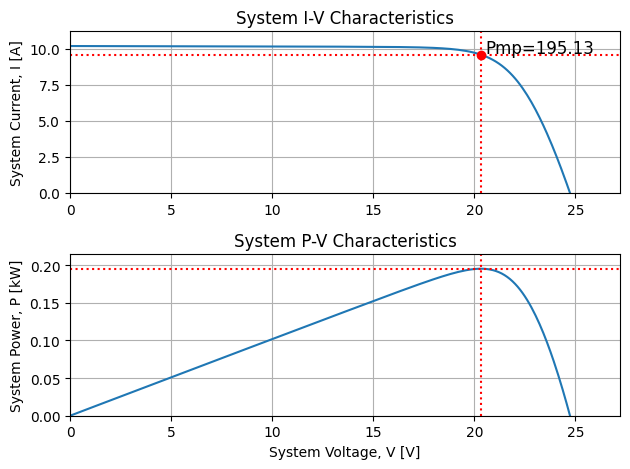

In [591]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm_12v])
plot_system(pvs)

## Case studies

All case studies are performed with predicted irradiance for Key West, FL on January 21, 2024.  For shaded cases, it is assumed that the shaded panel still generates power from diffuse irradiance predicted for this location.  In other words, the shaded panels are not experiencing a close sharp shadow, more like a cloudy day.

- Case 0 is a system of two flat mounted panels (in series and parallel).  This case will be the baseline for cases 1, 2, and 3.  

- Case 1 is a system of two panels angled slightly opposite of each other.  This case is analogous to what we often see on boats and RVs where the roof is slighly curved in the athwart dimension and panels are mounted following that curve.  

- Case 2 is a system of two panels where one is flat mounted, and the other is angled near optimally (45 degrees) for Key West in winter.  

- Case 3 is a system of 2 flat mounted panels showing the effect when one panel becomes shaded for both series and parallel configurations.  

- Case 4 is a system of 4 flat mounted panels showing the effect when one panel becomes shaded for both 4P and 2P2S configurations.

### Case 0.0 - Two flat 12V panels in parallel

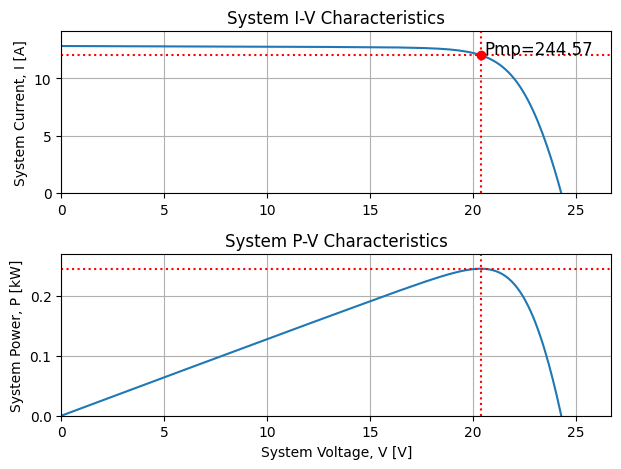

In [592]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm_12v])
sun = getSun(surface_tilt=0, shaded=False)
pvs.setSuns(sun)
plot_system(pvs)
pmp_baseline = pvs.Pmp

### Case 0.1 - Two flat 12V panels in series

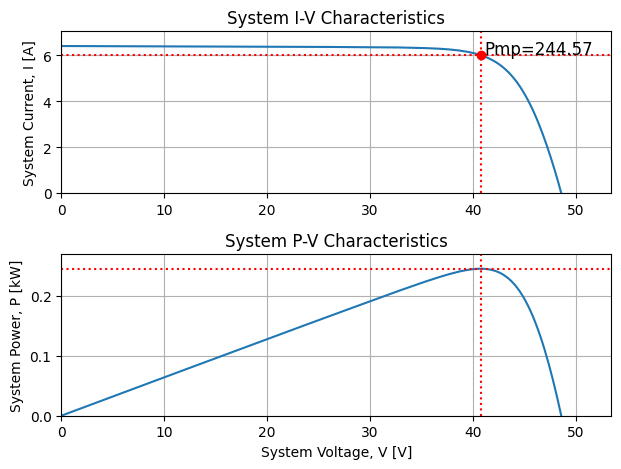

In [593]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm_12v, pvm_12v])
sun = getSun(surface_tilt=0, shaded=False)
pvs.setSuns(sun)
plot_system(pvs)

### Case 0 Summary
As expected performance for these two cases is identical.  Under ideal conditions, series may prove preferable since output would be the same while copper loss would be lower.

### Case 1.0 - Two opposite angled (5 degrees) panels in parallel

Reduction in output:  0.32 %


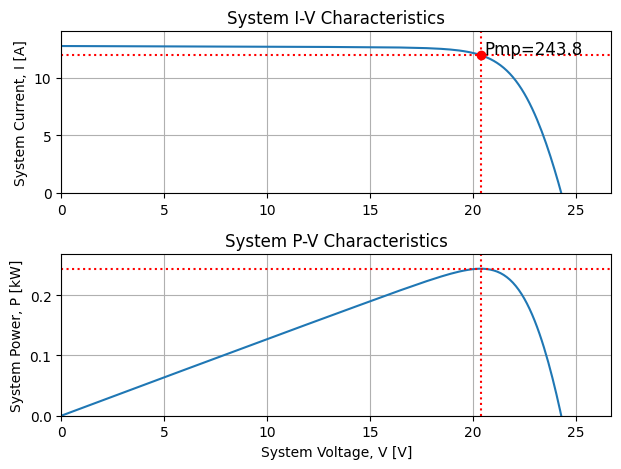

In [594]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm_12v])
sun_plus_5 = getSun(surface_tilt=-5, shaded=False)
sun_minus_5 = getSun(surface_tilt=5, shaded=False)
pvs.setSuns({0: {0: sun_minus_5}, 1: {0: sun_plus_5}})
plot_system(pvs)
derate10 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate10)*100,2), '%')

### Case 1.1 - Two opposite angled (5 degree) panels in series

Reduction in output:  4.38 %


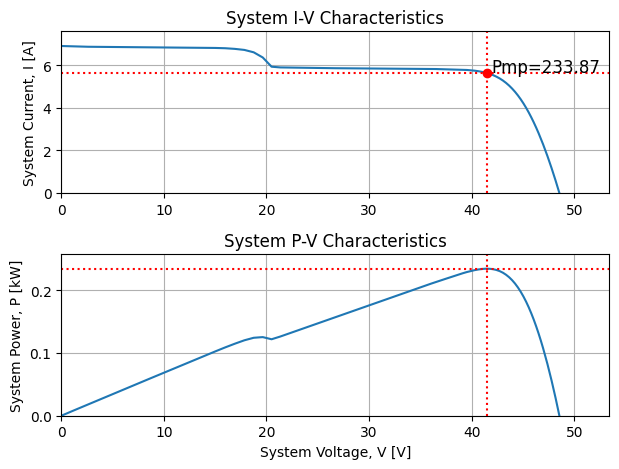

In [595]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm_12v, pvm_12v])
sun_plus_5 = getSun(surface_tilt=-5, shaded=False)
sun_minus_5 = getSun(surface_tilt=5, shaded=False)
pvs.setSuns({0: {0: sun_minus_5, 1: sun_plus_5}})
plot_system(pvs)
derate11 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate11)*100,2), '%')

### Case 1 Summary

Parallel results in a negligable reduction in output compared to a 4.38% loss for the series configuration.

### Case 2.0 - One flat panel and one 45 degree tilted panel in parallel

Reduction in output:  -20.46 %


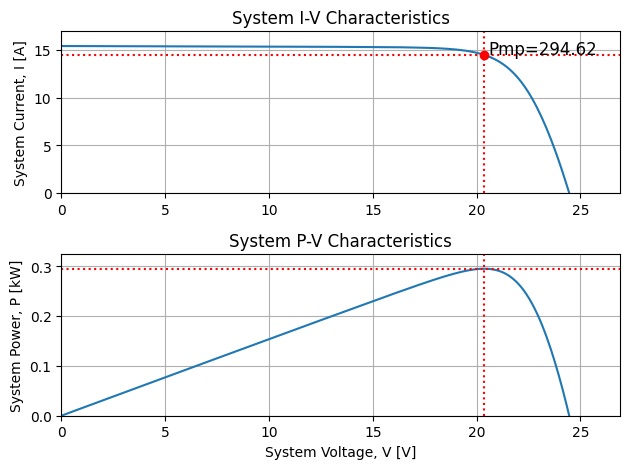

In [596]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm_12v])
sun_plus_45 = getSun(surface_tilt=45, shaded=False)
sun_flat = getSun(surface_tilt=0, shaded=False)
pvs.setSuns({0: {0: sun_plus_45}, 1: {0: sun_flat}})
plot_system(pvs)
derate20 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate20)*100,2), '%')

### Case 2.1 - One flat panel and one 45 degree tilted panel in series

Reduction in output:  -6.2 %


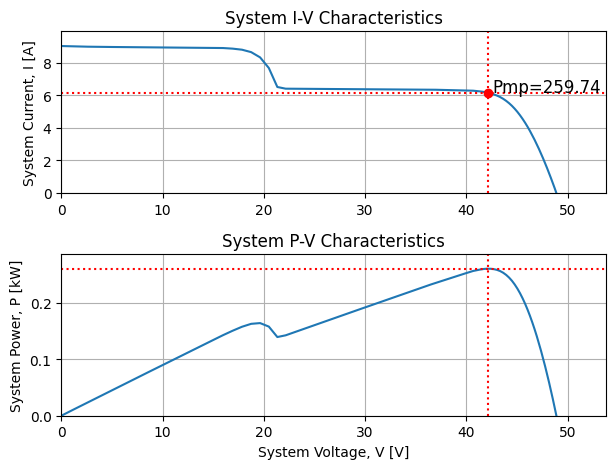

In [597]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm_12v, pvm_12v])
sun_plus_45 = getSun(surface_tilt=45, shaded=False)
sun_flat = getSun(surface_tilt=0, shaded=False)
pvs.setSuns({0: {0: sun_plus_45, 1: sun_flat}})
plot_system(pvs)
derate21 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate21)*100,2), '%')

### Case 2.2 One flat panel, one 45 degree tilted panel, separate MPPT controllers

Reduction in output:  -20.47 %


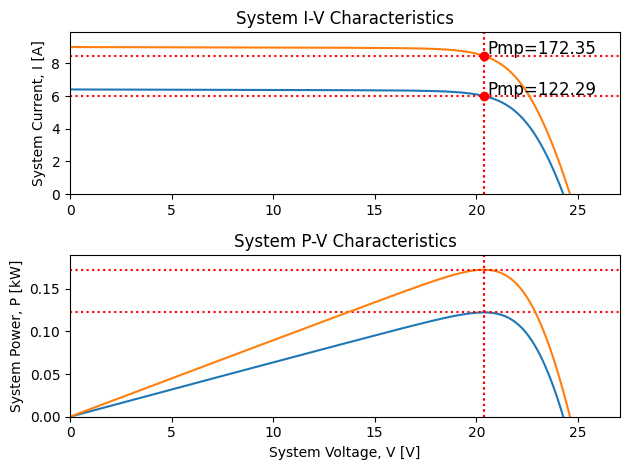

In [598]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm_12v])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_plus_45 = getSun(surface_tilt=45, shaded=False)
pvs.setSuns(sun_flat)
plot_system(pvs)
flat_power = pvs.Pmp
pvs.setSuns(sun_plus_45)
plot_system(pvs)
tilted_power = pvs.Pmp
derate22 = (flat_power + tilted_power) / pmp_baseline
print('Reduction in output: ', round((1-derate22)*100,2), '%')

### Case 2 Summary

The parallel case sees an increase of 20% power production, while the series configuration only sees and increase of 6% power productionl.  This situation clearly favors the parallel configuration.  Of note is the negligable benefit of a separate MPPT controller (0.01% better than parallel with a common MPPT).  This suggests that as long as the same panels are in use, such that Vmpp is the essentially the same, a separate MPPT is not justified even under different exposure conditions.

### Case 3.0 Two flat 12V panels, with one shaded, in parallel

Reduction in output:  41.9 %


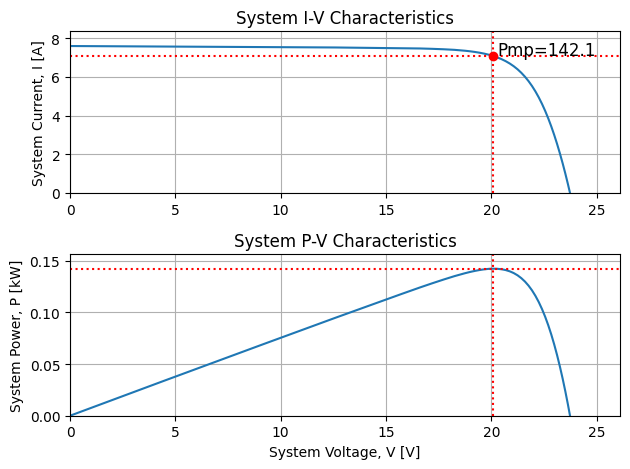

In [599]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm_12v])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat}, 1: {0: sun_flat_shaded}})
plot_system(pvs)
derate30 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate30)*100,2), '%')

### Case 3.1 Two flat 12V panels, with one shaded, in series

Reduction in output:  52.91 %


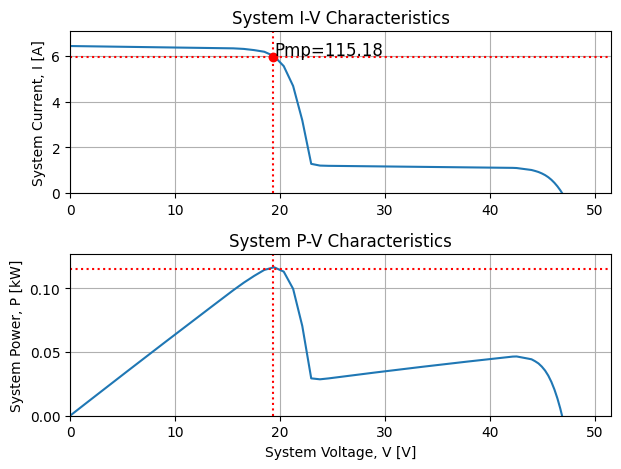

In [600]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm_12v, pvm_12v])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat, 1: sun_flat_shaded}})
plot_system(pvs)
derate31 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate31)*100,2), '%')

### Case 3 Summary

The parallel case sees a 42% reduction in power, while the series configuration sees a 53% reduction in power.  While both are significantly affected by shading, the parallel case is more resilliant.

### Case 4.0 - Four flat 12V panels in parallel (P), one shaded

Reduction in output:  20.99 %


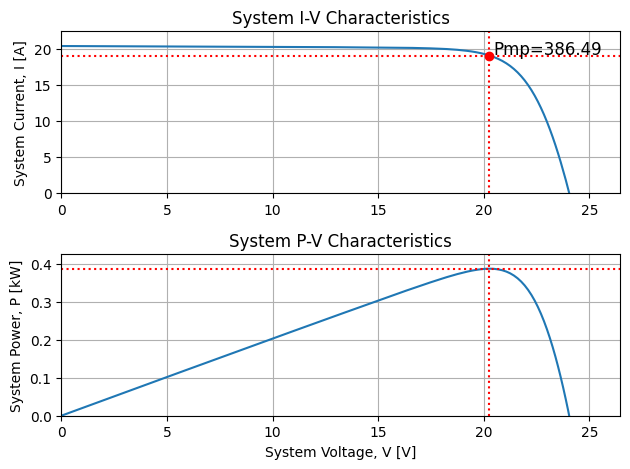

In [601]:
#Establish new baseline
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=4, pvmods=[pvm_12v])
sun_flat = getSun(surface_tilt=0, shaded=False)
pvs.setSuns(sun_flat)
pmp_baseline = pvs.Pmp

#Proceed with case 4.0
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat}, 1: {0: sun_flat}, 2: {0: sun_flat}, 3: {0: sun_flat_shaded}})
plot_system(pvs)
derate40 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate40)*100,2), '%')

### Case 4.1 - Four flat 12V panels in 2S2P, one shaded

Reduction in output:  40.77 %


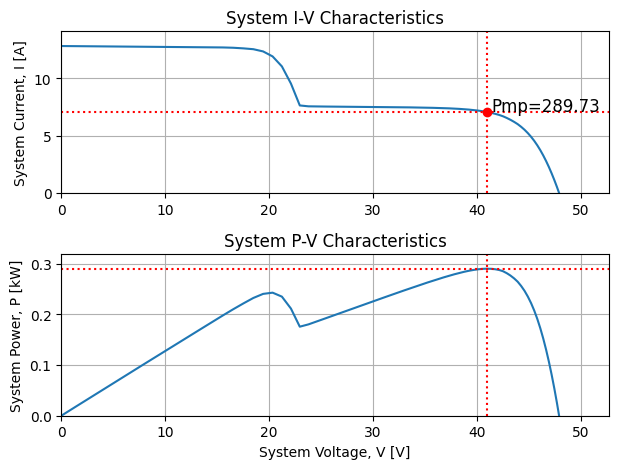

In [602]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm_12v, pvm_12v])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat, 1: sun_flat_shaded}, 1: {0: sun_flat, 1: sun_flat}})
plot_system(pvs)
derate41 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate41)*100,2), '%')

### Case 4 Summary

As in all other cases, the parallel configuration experiences less reduction in power (21%), compared to the 2S4P configuration (40.77%).  Of arguable more interest, is that the reduction in power in the 2S4P case exceeds the percentage of shaded panels (25%).  This strongly suggests parallel configurations are optimal for RV and marine applications when possible.